# 方案

In [ ]:
'''



方案一：pca+聚类--->类内打分均值替代空值(列为服装，则部分列的打分均值替代)--->PMF冷启动问题
方案二：中心切片定理+压缩感知--->PMF冷启动问题

方案一：
数据源：
（1）https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews?resource=download
（2）https://zhuanlan.zhihu.com/p/69356493?utm_id=0   https://zhuanlan.zhihu.com/p/57839798
数据获取：以服装为中心，获取的服装样本集包括如下特征：
                a. 服装的特征(尺寸分类、服装类别、服装品类)
                b. 发表评价的客户的特征(客户年龄、客户收入、客户体重、客户历史订单量、客户评分、客户评论)
                PS：由于数据集的客户特征较少，因此从数据源补充搜集了客户年龄、客户收入、客户体重、客户历史订单量这四个客户特征
数据处理：
（1）数据清洗、数据描述(统计分布分析)
    结论：
（2）综合评分：
        1. 情感分析(朴素贝叶斯分类器)
        2. 综合评分计算：map(评论态度,±1)*置信度*客户评分*正反馈计数
    结论：
（3）对客户特征与服装特征分别作PCA特征降维处理(实际应用场景的特征数量会非常大，需要作特征降维)
    结论：通过方差解释率筛选，服装特征保留2个PCA特征分量，客户特征保留4个PCA特征分量(全部保留)
（4）聚类处理，用于对服装与客户群体归类，以在PMF算法推荐过程中减少推荐基数，从而达到加速的目的，（同时若加入分类算法，冷启动）：
        1. 客户聚类：4个PCA特征分量
        2. 服装聚类：2个PCA特征分量
        PS：聚类评价指标选择平均轮廓系数，越大越好，大于0.1可认为有效
    结论：客户类簇数量为5，服装类簇数量为32
PMF算法推荐：
（1）矩阵评分定义：每个客户类簇对每个服装类簇的“综合评分”取客户类簇内的均值
（2）数据训练与预测

模型结论：牺牲一定个性化推荐的程度与精度，加快推荐速度，同时还可改进模型以获得冷启动能力
模型改进：加入高精度分类算法，通过预测新加入的客户或服装所属的类簇，以对其作对应的推荐
PS：原PMF算法是服装->客户，本模型是服装类簇->客户类簇，加速推荐且解决冷启动



方案二：
数据源：（有，但没找）（存在评分缺失问题）
数据获取：客户-服装的评分（直接构成表）
数据处理：
（1）数据清洗
（2）直接构建PMF评分矩阵，进行投影
（3）对每个投影进行压缩感知恢复，并作时域卷积校正
（4）得到新的PMF评分矩阵，进行训练
可解决训练集缺失、算法运算速度的问题



'''

# 项目主题

In [ ]:
'''
一种基于类簇的快速推荐系统设计

''' 

# 导入库

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics import mean_absolute_error, mean_squared_error

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
matplotlib.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set(font='SimSun', font_scale=1.2)


Bad key text.latex.preview in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably need to get an updated matplotli

In [2]:
dfr = pd.read_csv("Womens Clothing E-Commerce Reviews-folded.csv")
dfr.head()

,Unnamed: 0,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Revenue,Weight,Historical Order Quantity
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,2272,71.3,27
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,3594,87.4,112
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,4923,67.3,40
3,3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,3193,87.2,55
4,4,847,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1473,54.8,59


In [3]:
'''   
 
Clothing ID：服装ID
Age：客户年龄
Review Text：评论
Rating：评分
Recommended IND：推荐指数，用二进制表示是否推荐该商品，0代表不推荐，1代表推荐
Positive Feedback Count：正反馈计数，认为该评价有用的其他客户数量
Division Name：尺寸分类，按照服装尺寸划分，如正常尺码、小码服装等
Department Name：服装类别，按照服装类别划分，如上装下装、连衣裙等
Class Name：服装品类，按照服装具体品类划分，如针织衫、女式衬衫、牛仔裤等
Revenue：客户收入
Weight：客户体重
Historical Order Quantity：客户历史订单量
'''


'   \n \n*Clothing ID：服装ID\n*Age：客户年龄\n Title：评价标题\n*Review Text：评论\n*Rating：评分\n*Recommended IND：推荐指数，用二进制表示是否推荐该商品，0代表不推荐，1代表推荐\n*Positive Feedback Count：正反馈计数，认为该评价有用的其他客户数量\n*Division Name：尺寸分类，按照服装尺寸划分，如正常尺码、小码服装等\n*Department Name：服装类别，按照服装类别划分，如上装下装、连衣裙等\n*Class Name：服装品类，按照服装具体品类划分，如针织衫、女式衬衫、牛仔裤等\n'

# 数据清洗

## 数据重排

In [3]:
df = pd.DataFrame({'服装ID':dfr['Clothing ID'],  # 服装
                  '尺寸分类':dfr['Division Name'],
                  '服装类别':dfr['Department Name'],
                  '服装品类':dfr['Class Name'],
                  '客户年龄':dfr['Age'],   # 客户
                  '评论':dfr['Review Text'],
                  '客户评分':dfr['Rating'],
                  '正反馈计数':dfr['Positive Feedback Count'],
                  '推荐指数':dfr['Recommended IND'],
                  '客户收入':dfr['Revenue'],
                  '客户体重':dfr['Weight'],
                  '客户历史订单量':dfr['Historical Order Quantity']})

df.head() 

,服装ID,尺寸分类,服装类别,服装品类,客户年龄,评论,客户评分,正反馈计数,推荐指数,客户收入,客户体重,客户历史订单量
0,767,Initmates,Intimate,Intimates,33,Absolutely wonderful - silky and sexy and comf...,4,0,1,2272,71.3,27
1,1080,General,Dresses,Dresses,34,Love this dress! it's sooo pretty. i happene...,5,4,1,3594,87.4,112
2,1077,General,Dresses,Dresses,60,I had such high hopes for this dress and reall...,3,0,0,4923,67.3,40
3,1049,General Petite,Bottoms,Pants,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,1,3193,87.2,55
4,847,General,Tops,Blouses,47,This shirt is very flattering to all due to th...,5,6,1,1473,54.8,59


## 缺失值处理

In [4]:
# 去除包含空值的行
df = df.dropna()

## 编码

In [5]:
# 尺寸分类 服装类别 服装品类
df_original = df.copy()

def encoding(arr):
    cTable = []
    for data in arr:
        rel = []
        for i in data:
            if i not in rel:
                rel.append(i)
        red = {}
        for num,cato in enumerate(rel):
            red[cato] = num
        cTable.append(red)
        
    return cTable

arr = [df['尺寸分类'], df['服装类别'], df['服装品类']]
cTable = encoding(arr)

for i in cTable:
    print(i)

{'Initmates': 0, 'General': 1, 'General Petite': 2}
{'Intimate': 0, 'Dresses': 1, 'Bottoms': 2, 'Tops': 3, 'Jackets': 4, 'Trend': 5}
{'Intimates': 0, 'Dresses': 1, 'Pants': 2, 'Blouses': 3, 'Knits': 4, 'Outerwear': 5, 'Lounge': 6, 'Sweaters': 7, 'Skirts': 8, 'Fine gauge': 9, 'Sleep': 10, 'Jackets': 11, 'Swim': 12, 'Trend': 13, 'Jeans': 14, 'Legwear': 15, 'Shorts': 16, 'Layering': 17, 'Casual bottoms': 18, 'Chemises': 19}


## 编码替换

In [6]:
replaced_column = df['尺寸分类'].map(cTable[0])
df['尺寸分类'] = replaced_column
replaced_column = df['服装类别'].map(cTable[1])
df['服装类别'] = replaced_column
replaced_column = df['服装品类'].map(cTable[2])
df['服装品类'] = replaced_column

df.head(10)

,服装ID,尺寸分类,服装类别,服装品类,客户年龄,评论,客户评分,正反馈计数,推荐指数,客户收入,客户体重,客户历史订单量
0,767,0,0,0,33,Absolutely wonderful - silky and sexy and comf...,4,0,1,2272,71.3,27
1,1080,1,1,1,34,Love this dress! it's sooo pretty. i happene...,5,4,1,3594,87.4,112
2,1077,1,1,1,60,I had such high hopes for this dress and reall...,3,0,0,4923,67.3,40
3,1049,2,2,2,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,1,3193,87.2,55
4,847,1,3,3,47,This shirt is very flattering to all due to th...,5,6,1,1473,54.8,59
5,1080,1,1,1,49,"I love tracy reese dresses, but this one is no...",2,4,0,133,80.7,55
6,858,2,3,4,39,I aded this in my basket at hte last mintue to...,5,1,1,2421,63.8,0
7,858,2,3,4,39,"I ordered this in carbon for store pick up, an...",4,4,1,419,74.9,47
8,1077,1,1,1,24,I love this dress. i usually get an xs but it ...,5,0,1,126,59.3,28
9,1077,1,1,1,34,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,0,1,465,75.4,63


# 数据描述

In [8]:
'''
观察数据分布情况
该数据对推荐模型而言具有实用价值：
（1）服装的尺寸分类、服装类别、服装品类平均分布
（2）客户年龄呈现正态分布，并集中于社会主体年龄群体
（3）客户评分呈现均匀分布，服装样本的受众与评价具有多样性
（4）服装的尺寸分类、服装类别、服装品类与客户年龄、客户综合评分呈现二维高斯分布或多峰分布，呈现一定相关性，具有聚类价值
PS：（4）见3.6
'''

'\n观察数据分布情况\n该数据对推荐模型而言具有实用价值：\n（1）服装的尺寸分类、服装类别、服装品类平均分布\n（2）客户年龄呈现正态分布，并集中于社会主体年龄群体\n（3）客户评分呈现均匀分布，服装样本的受众与评价具有多样性\n（4）服装的尺寸分类、服装类别、服装品类与客户年龄、客户综合评分呈现二维高斯分布或多峰分布，呈现一定相关性，具有聚类价值\nPS：（4）见3.6\n'

## 统计量计算

In [7]:
# 统计量计算
df_stastic = pd.concat([df['尺寸分类'].describe().astype(int),
                       df['服装类别'].describe().astype(int),
                       df['服装品类'].describe().astype(int),
                       df['客户评分'].describe().astype(int),
                       df['客户年龄'].describe().astype(int)], axis=1)
df_stastic = df_stastic.reset_index().rename(columns={'index': '统计量'})
# 解码统计量
df_stastic_dec = df_stastic.copy()

# 解码
# 字典反转
r_cTable = []
for dic in cTable:
    r_cTable.append({v: k for k, v in dic.items()})
# 使用map函数进行替换，并将NaN替换为原始值
replaced_column = df_stastic_dec['尺寸分类'].map(r_cTable[0]).fillna(df_stastic_dec['尺寸分类']) 
df_stastic_dec['尺寸分类'] = replaced_column
replaced_column = df_stastic_dec['服装类别'].map(r_cTable[1]).fillna(df_stastic_dec['服装类别']) 
df_stastic_dec['服装类别'] = replaced_column
replaced_column = df_stastic_dec['服装品类'].map(r_cTable[2]).fillna(df_stastic_dec['服装品类']) 
df_stastic_dec['服装品类'] = replaced_column
# 保存
df_stastic_dec.to_excel("统计量.xlsx")
# 显示
display(df_stastic_dec)
display(df_stastic)

,统计量,尺寸分类,服装类别,服装品类,客户评分,客户年龄
0,count,22628,22628,22628,22628,22628
1,mean,General,Bottoms,Knits,4,43
2,std,Initmates,Dresses,Knits,1,12
3,min,Initmates,Intimate,Intimates,1,18
4,25%,General,Dresses,Dresses,4,34
5,50%,General,Bottoms,Knits,5,41
6,75%,General Petite,Tops,Sweaters,5,52
7,max,General Petite,Trend,Chemises,5,99


,统计量,尺寸分类,服装类别,服装品类,客户评分,客户年龄
0,count,22628,22628,22628,22628,22628
1,mean,1,2,4,4,43
2,std,0,1,4,1,12
3,min,0,0,0,1,18
4,25%,1,1,1,4,34
5,50%,1,2,4,5,41
6,75%,2,3,7,5,52
7,max,2,5,19,5,99


## 分布图绘制

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "interpolation" which is no longer supported as of 3.3 and will become an error in 3.6
  from ipykernel import kernelapp as app


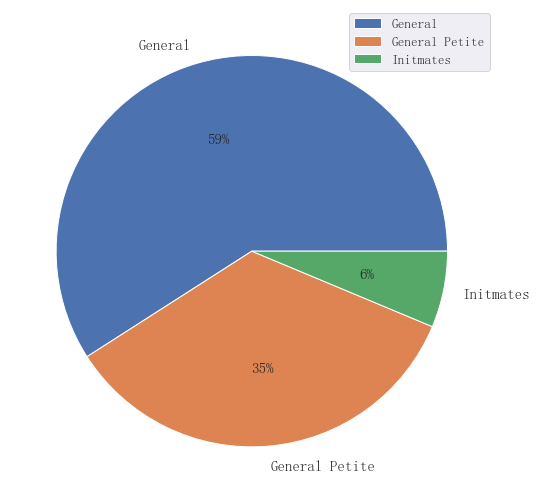

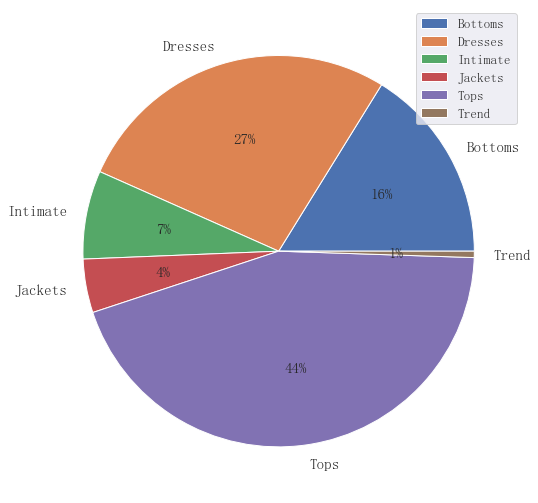

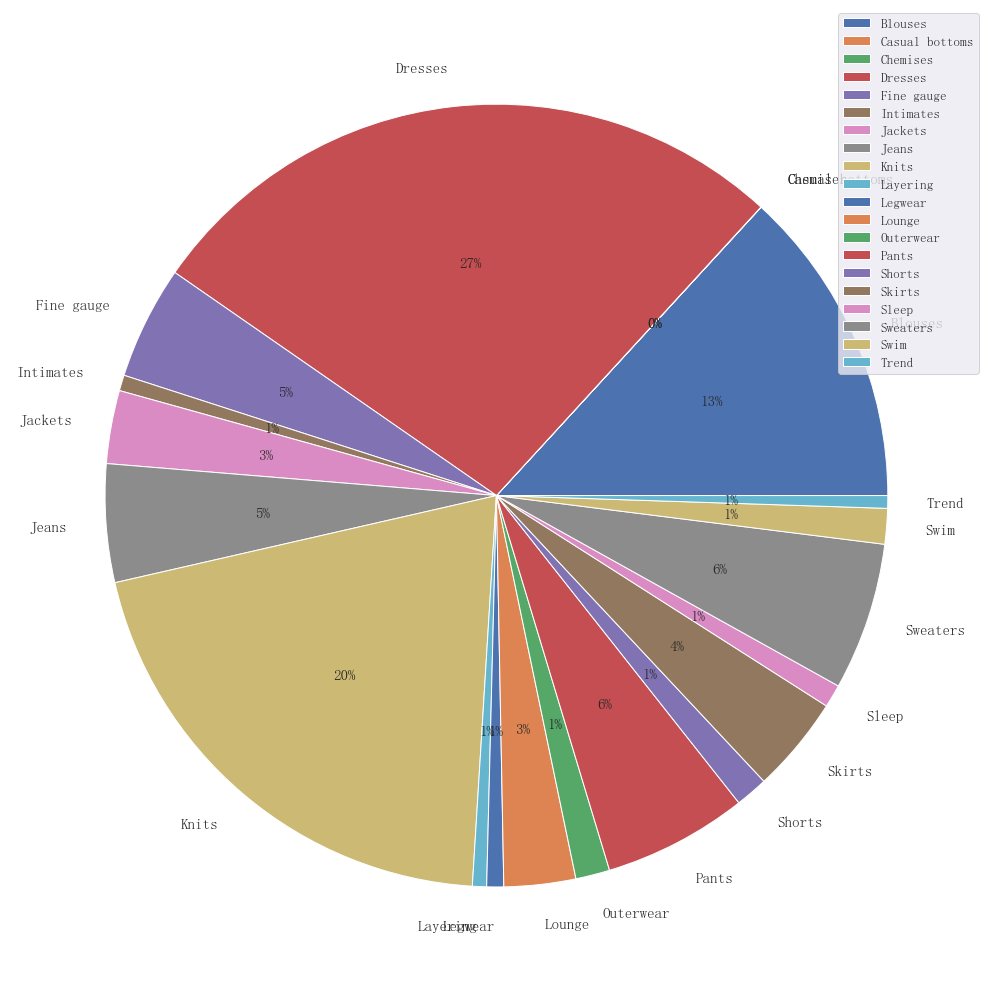

In [8]:
# 尺寸分类
arr = df_original['尺寸分类'].value_counts()
dfplot = pd.DataFrame({'尺寸分类':[i for i in arr.keys()], '数量':list(arr)})
dfplot.groupby(['尺寸分类']).sum().plot(kind='pie', y='数量', autopct='%1.0f%%', figsize=(15,9), fontsize=15, ylabel='')
plt.savefig('尺寸分类pie.png')
# 服装类别
arr = df_original['服装类别'].value_counts()
dfplot = pd.DataFrame({'服装类别':[i for i in arr.keys()], '数量':list(arr)})
dfplot.groupby(['服装类别']).sum().plot(kind='pie', y='数量', autopct='%1.0f%%', figsize=(15,9), fontsize=15, ylabel='')
plt.savefig('服装类别pie.png')
# 服装品类
arr = df_original['服装品类'].value_counts()
dfplot = pd.DataFrame({'服装品类':[i for i in arr.keys()], '数量':list(arr)})
dfplot.groupby(['服装品类']).sum().plot(kind='pie', y='数量', autopct='%1.0f%%', figsize=(21,18), fontsize=15, ylabel='')
plt.savefig('服装品类pie.png', interpolation='bicubic')


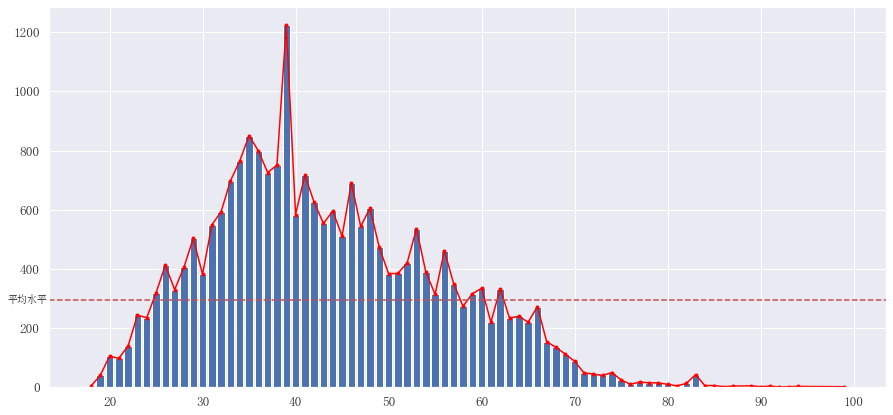

In [11]:
# 客户年龄 
df_age = pd.DataFrame({'年龄':df['客户年龄'].value_counts().index, 
                       '计数':df['客户年龄'].value_counts()}).sort_values('年龄')
plt.figure(figsize=(15,7))
# 绘制直方图
plt.bar(df_age['年龄'], df_age['计数'])
# 绘制趋势折线
plt.plot(df_age['年龄'], df_age['计数'], color='red', marker='o', markersize=3)
# 在直方图上绘制指示线
average_count = np.mean(df_age['计数']) # 计数平均
plt.axhline(y=average_count, color='r', linestyle='--')
plt.text(9, 300, '平均水平', fontsize=10, color='k', va='center')
plt.savefig('客户年龄bar.png')



<Figure size 1080x504 with 0 Axes>

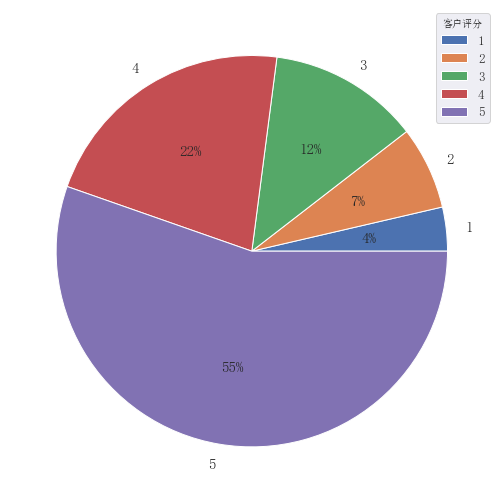

In [12]:
# 客户评分  
df_mark = pd.DataFrame({'评分':df['客户评分'].value_counts().index, 
                       '计数':df['客户评分'].value_counts()}).sort_values('评分')
plt.figure(figsize=(15,7))
# 绘制饼图
df_mark.groupby(['评分']).sum().plot(kind='pie', y='计数', autopct='%1.0f%%', figsize=(15,9), fontsize=15, ylabel='')
plt.legend(title='客户评分')
plt.savefig('客户评分pie.png')

# 综合评分

## 情感分析

In [8]:
# 模型训练
# 定义一个用于提取特征的函数
def extract_features(word_list):
    return dict([(word, True) for word in word_list])

# 用NLTK提供的电影评论数据进行模型训练
# 加载积极与消极评论
positive_fileids = movie_reviews.fileids('pos')
negative_fileids = movie_reviews.fileids('neg')

# 将这些评论数据分成积极评论和消极评论 
features_positive = [(extract_features(movie_reviews.words(fileids=[f])), 
        'Positive') for f in positive_fileids]
features_negative = [(extract_features(movie_reviews.words(fileids=[f])), 
        'Negative') for f in negative_fileids]

# 分成训练数据集（80%）和测试数据集（20%）
threshold_factor = 0.8
threshold_positive = int(threshold_factor * len(features_positive))
threshold_negative = int(threshold_factor * len(features_negative))

# 提取特征
features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]  
print ("\nNumber of training datapoints:", len(features_train))
print ("Number of test datapoints:", len(features_test))

# 训练朴素贝叶斯分类器
classifier = NaiveBayesClassifier.train(features_train)
print ("\nAccuracy of the classifier:", nltk.classify.util.accuracy(classifier, features_test))



Number of training datapoints: 1600
Number of test datapoints: 400

Accuracy of the classifier: 0.735


In [9]:
df_sensitive = pd.DataFrame(columns=['评论态度', '置信度', '综合评分'])

for review in df['评论']:
    probdist = classifier.prob_classify(extract_features(review.split()))
    pred_sentiment = probdist.max()
    df_sensitive = df_sensitive.append({'评论态度':pred_sentiment, 
                                        '置信度':round(probdist.prob(pred_sentiment), 2),
                                       '综合评分':0}, ignore_index=True)

print(df_sensitive.shape)

(22628, 3)


## 综合评分计算

In [10]:
# 对象异常处理
df_sensitive.to_excel('临时.xlsx', index=False)
df.to_excel('重排数据.xlsx', index=False)

df_sensitive = pd.read_excel('临时.xlsx')
df = pd.read_excel('重排数据.xlsx')

In [11]:
# 数据拼接
df = pd.concat([df, df_sensitive], axis=1)

# 评分计算
df['评论态度'] = df['评论态度'].map({'Positive':int(1),'Negative':int(0)})
df['综合评分'] = df['置信度']*df['客户评分']*(df['评论态度'].map({0:int(-1),1:int(1)}))*df['正反馈计数']
df.head()

,服装ID,尺寸分类,服装类别,服装品类,客户年龄,评论,客户评分,正反馈计数,推荐指数,客户收入,客户体重,客户历史订单量,评论态度,置信度,综合评分
0,767,0,0,0,33,Absolutely wonderful - silky and sexy and comf...,4,0,1,2272,71.3,27,1,0.89,0.0
1,1080,1,1,1,34,Love this dress! it's sooo pretty. i happene...,5,4,1,3594,87.4,112,1,0.99,19.8
2,1077,1,1,1,60,I had such high hopes for this dress and reall...,3,0,0,4923,67.3,40,1,0.95,0.0
3,1049,2,2,2,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,1,3193,87.2,55,0,0.59,-0.0
4,847,1,3,3,47,This shirt is very flattering to all due to th...,5,6,1,1473,54.8,59,1,0.62,18.6


# 服装特征降维

In [13]:
# 数据集切分函数
def split_dataset(arr, train_ratio, test_ratio):
    # 计算切分点
    n = arr.shape[0]
    train_end = int(train_ratio * n)
    test_end = int((train_ratio+test_ratio) * n)
    # 切分数据集
    train = arr[:train_end, :]
    test = arr[train_end:test_end, :]
    val = arr[test_end:, :]
    
    return train, test, val

In [14]:
# 标准化处理
scaler = StandardScaler()
arr_scaled = scaler.fit_transform(df.iloc[:,1:4])
arr_scaled = np.round(arr_scaled, 3)

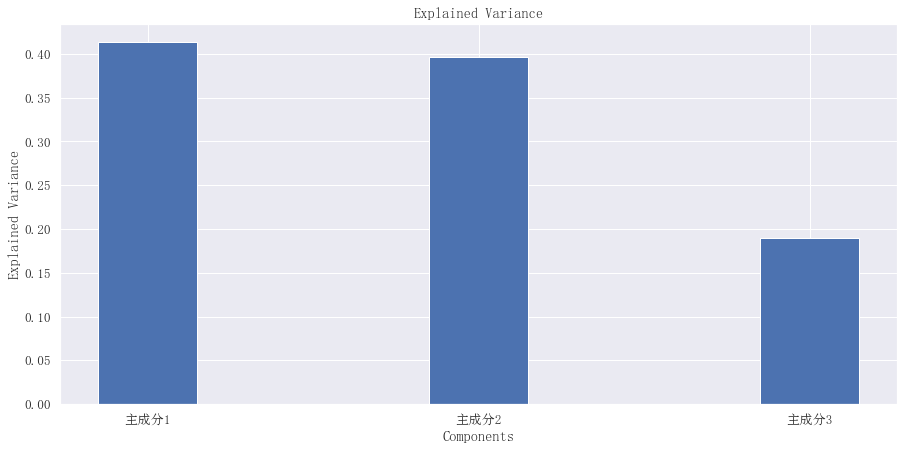

(4526, 2)


In [15]:
# 切分数据集
df_train, df_test, df_val = split_dataset(arr_scaled, train_ratio=0.6, test_ratio=0.2)

# 初始化PCA对象
pca = PCA(n_components=None) 
pca.fit(df_train)

# 输出每个主成分的方差解释率
plt.figure(figsize=(15,7))
plt.bar(['主成分'+str(i) for i in range(1,len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_, width=0.3)
plt.title('Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.savefig("方差解释率-服装.png")
plt.show()

# 根据图中的解释方差率选择合适的K值
# https://blog.csdn.net/huanfeng_AI/article/details/128357648
# n_components="mle"：可通过最大似然估计自动估计维度  
K = 2
pca = PCA(n_components=K)
pca.fit(df_train)

# 对数据进行降维处理
df_reduced = pca.transform(df_test)

# 打印降维后的数据形状，确认降维效果
print(df_reduced.shape)

# 数据降维
arr_pca= pca.transform(arr_scaled)

In [16]:
# 降维矩阵
df_pca = pd.DataFrame({'clothing_pca1':[i[0] for i in arr_pca],
                      'clothing_pca2':[i[1] for i in arr_pca]})
df_pca.head()

,clothing_pca1,clothing_pca2
0,-2.990523,0.743969
1,-1.419207,-0.306266
2,-1.419207,-0.306266
3,0.152513,-1.357184
4,0.250203,0.071729


# 客户特征降维

In [17]:
# 标准化处理   
scaler = StandardScaler()
arr_scaled = scaler.fit_transform(np.array(df[['客户年龄','客户收入','客户体重','客户历史订单量']]))
arr_scaled = np.round(arr_scaled, 3)

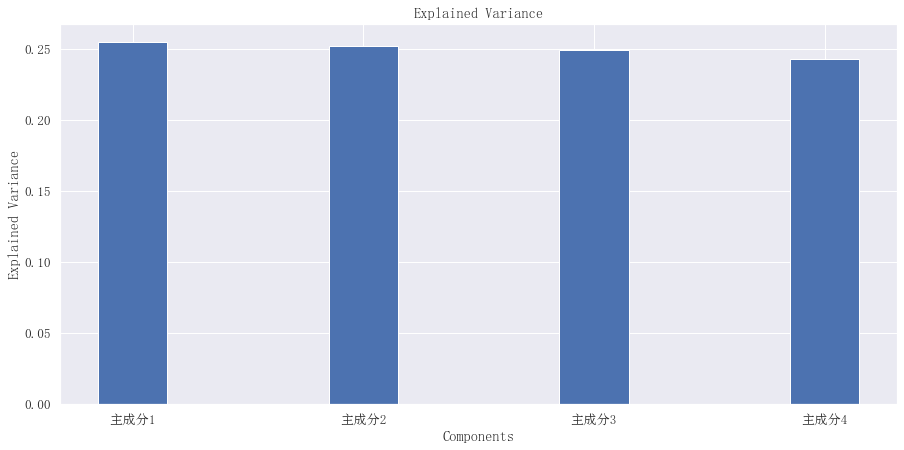

(4526, 4)


In [18]:
# 切分数据集
df_train, df_test, df_val = split_dataset(arr_scaled, train_ratio=0.6, test_ratio=0.2)

# 初始化PCA对象
pca = PCA(n_components=None) 
pca.fit(df_train)

# 输出每个主成分的方差解释率
plt.figure(figsize=(15,7))
plt.bar(['主成分'+str(i) for i in range(1,len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_, width=0.3)
plt.title('Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.savefig("方差解释率-客户.png")
plt.show()

# 根据图中的解释方差率选择合适的K值。
K = 4
pca = PCA(n_components=K)
pca.fit(df_train)

# 对数据进行降维处理
df_reduced = pca.transform(df_test)

# 打印降维后的数据形状，确认降维效果
print(df_reduced.shape)

# 数据降维
arr_pca= pca.transform(arr_scaled)

In [19]:
# 降维数据
df_pca['client_pca1'] = [i[0] for i in arr_pca]
df_pca['client_pca2'] = [i[1] for i in arr_pca]
df_pca['client_pca3'] = [i[2] for i in arr_pca]
df_pca['client_pca4'] = [i[3] for i in arr_pca]
df_pca.head()

,clothing_pca1,clothing_pca2,client_pca1,client_pca2,client_pca3,client_pca4
0,-2.990523,0.743969,-0.501847,0.041196,-0.692321,-0.988304
1,-1.419207,-0.306266,2.278335,0.885571,-0.206436,0.882800
2,-1.419207,-0.306266,-1.374456,1.116983,1.204917,0.495068
3,0.152513,-1.357184,0.760771,0.110989,1.145467,-0.135622
4,0.250203,0.071729,-1.543891,-0.350495,-1.020567,1.051752


# 特征关联性评估

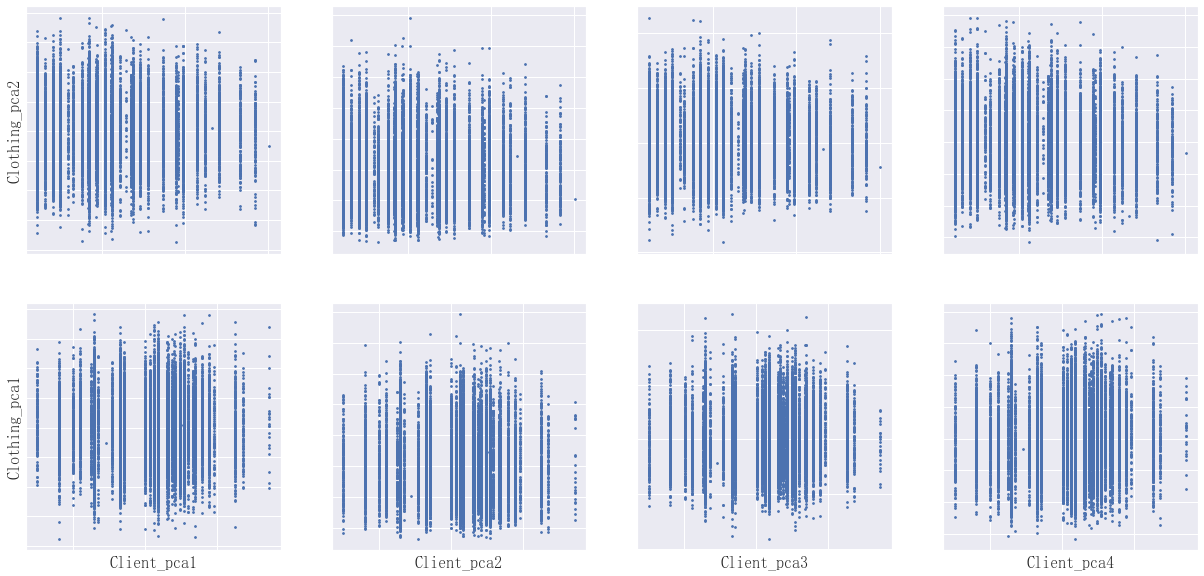

In [20]:
# # 服装的PCA成分1、PCA成分2与客户的年龄、客户综合评分呈现多峰的分布，呈现极强的相关性，具有推荐价值

plt.figure(figsize=(21,10))
num=1
for i in range(1,-1,-1):
    for j in range(2,6):
        plt.subplot(2, 4, num)
        plt.scatter(df_pca.iloc[:,i],df_pca.iloc[:,j], s=3)
        if num==1 or num==5:
            plt.ylabel("Clothing_pca{}".format(i+1), fontsize=16)
        if num>=5:
            plt.xlabel("Client_pca{}".format(j-1), fontsize=16)
        plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        num+=1
plt.savefig("pca_crossfig.jpeg")
plt.show()

# 群体聚类

## 服装群体聚类

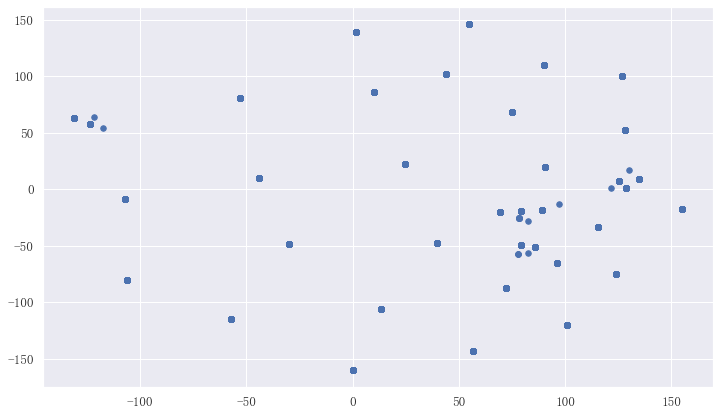

'\n结论：\n每团样本的分布集中程度比较高，采用kmeans++方法(最大优势：效率高)\n\n'

In [21]:
# 绘图观察
# 流形学习-常用于降维可视化
# 相比较pca，可以避免在引入不同类别的数据后，在降维过程中产生的重叠问题
# https://blog.csdn.net/WuKai1207/article/details/126666056; https://blog.csdn.net/cuisidong1997/article/details/134378856
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42, n_jobs=-1) #n_components=2降维为2维并且可视化
X_tsne = tsne.fit_transform(np.array(df[['尺寸分类','服装类别','服装品类']]))

plt.figure(figsize=(12,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=30)
plt.show()


# plt.figure(figsize=(12,7))
# plt.scatter(df_pca['clothing_pca1'],df_pca['clothing_pca2'],s=120)
# plt.show()

'''
结论：
每团样本的分布集中程度比较高，采用kmeans++方法(最大优势：效率高)

'''

In [46]:
# 轮廓系数曲线
# https://blog.csdn.net/weixin_44344462/article/details/89337770
numsil_scores = []

for num in range(2,33):
    clust = KMeans(n_clusters=num, init='k-means++')
    # 开始聚类
    arr_pca = np.array(df_pca[['clothing_pca1','clothing_pca2']])
    clust.fit(arr_pca)
    silhouette = silhouette_score(arr_pca, clust.labels_)
    numsil_scores.append([num, silhouette])
    print("mum_samples: {} | the silhouette score: {}".format(num, silhouette))

mum_samples: 2 | the silhouette score: 0.4682693514735484
mum_samples: 3 | the silhouette score: 0.519835024365223
mum_samples: 4 | the silhouette score: 0.5615957228698889
mum_samples: 5 | the silhouette score: 0.5729377708775784
mum_samples: 6 | the silhouette score: 0.6636700343168657
mum_samples: 7 | the silhouette score: 0.6753958021497688
mum_samples: 8 | the silhouette score: 0.6854127402918535
mum_samples: 9 | the silhouette score: 0.7073880805779457
mum_samples: 10 | the silhouette score: 0.721540071548939
mum_samples: 11 | the silhouette score: 0.7581428301262416
mum_samples: 12 | the silhouette score: 0.7744950550029117
mum_samples: 13 | the silhouette score: 0.8032556706103798
mum_samples: 14 | the silhouette score: 0.8322945210781588
mum_samples: 15 | the silhouette score: 0.848817053690212
mum_samples: 16 | the silhouette score: 0.8538415509554454
mum_samples: 17 | the silhouette score: 0.8598630989658297
mum_samples: 18 | the silhouette score: 0.8757574517271114
mum_samp

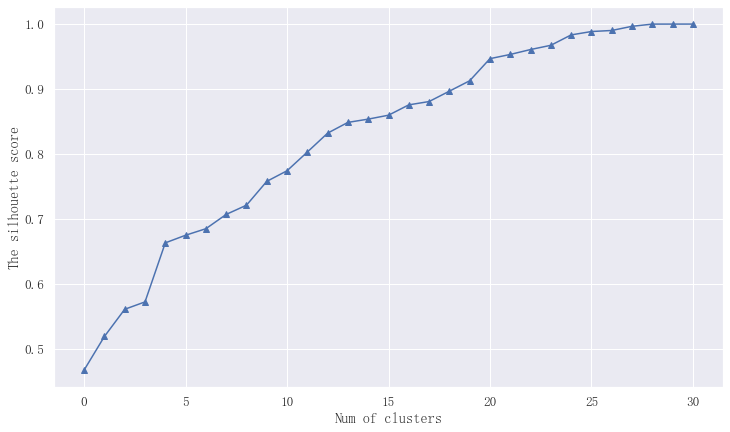

'\n当聚类中心个数为32时，轮廓系数最大，聚类效果最好\n\n'

In [53]:
# 轮廓系数绘制
plt.figure(figsize=(12,7))
plt.plot([i[1] for i in numsil_scores],'-^')
plt.xlabel('Num of clusters')
plt.ylabel('The silhouette score')
plt.show()

'''
结论：
当聚类中心个数为32时，轮廓系数最大，聚类效果最好
'''

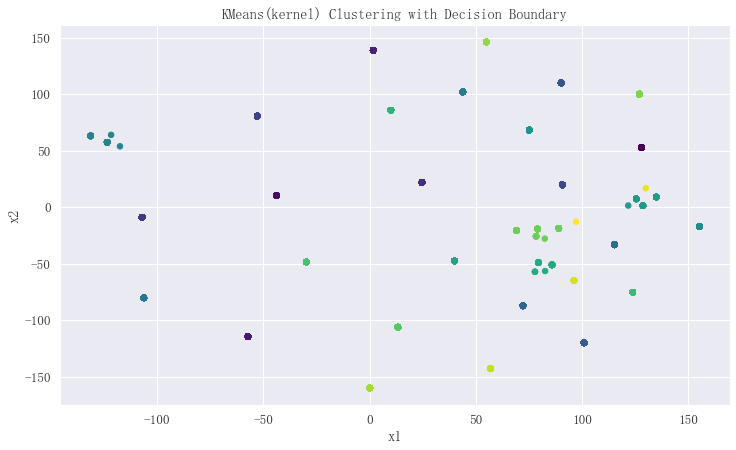

the silhouette score: 0.9882953763008118


In [22]:
# KMeans
clust = KMeans(n_clusters=32, init='k-means++')
clust.fit(np.array(df_pca[['clothing_pca1','clothing_pca2']]))

x1 = X_tsne[:,0]
x2 = X_tsne[:,1]
z = clust.labels_ 

# 绘制原始数据和聚类中心  
plt.figure(figsize=(12,7))
plt.scatter(x1, x2, c=z, cmap='viridis', marker='o', s=30)  


plt.title('KMeans(kernel) Clustering with Decision Boundary')  
plt.xlabel('x1')  
plt.ylabel('x2')  
plt.show()


# 轮廓系数
silhouette = silhouette_score(X_tsne, z)
print("the silhouette score: {}".format(silhouette))

## 客户群体聚类

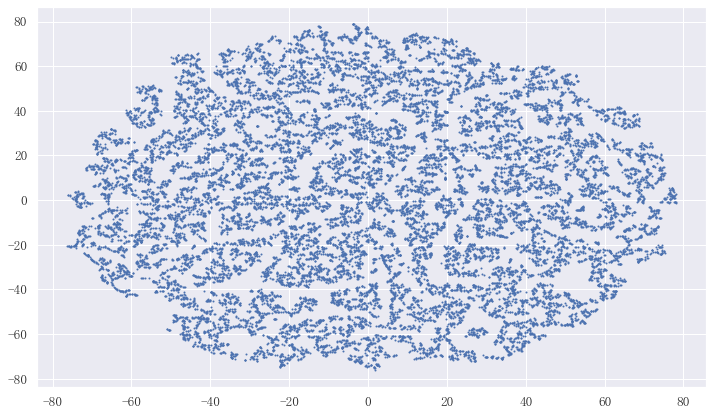

'\n结论：\n非线性边界，KMeans等方法不适用，用谱聚类核函数或DBSCAN方法\nDBSCAN不适用大批量数据处理，谱聚类（核kmeans）更实用\n'

In [23]:
# t-sne降维观察
# 流形学习-常用于降维可视化
# 相比较pca，可以避免在引入不同类别的数据后，在降维过程中产生的重叠问题，更适用于降维可视化
# https://blog.csdn.net/WuKai1207/article/details/126666056; https://blog.csdn.net/cuisidong1997/article/details/134378856

tsne = manifold.TSNE(n_components=2, init='pca', random_state=42, n_jobs=-1) #n_components=2降维为2维并且可视化
X_tsne = tsne.fit_transform(np.array(df_pca.iloc[:,2:]))

plt.figure(figsize=(12,7))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=1)
plt.show()

'''
结论：
非线性边界，KMeans等方法不适用，用谱聚类核函数或DBSCAN方法
DBSCAN不适用大批量数据处理，谱聚类（核kmeans）更实用
'''


In [ ]:
# 轮廓系数
numsil_scores = []

for num in range(40,200): # 2,100(初步确定2~15，5最好)
    clust = SpectralClustering(n_clusters=num, affinity='nearest_neighbors', n_neighbors=100, 
                           assign_labels='discretize', degree=3, n_jobs=-1, random_state=42)
    # 开始聚类
    arr_pca = np.array(df_pca.iloc[:5000,2:])
    clust.fit(arr_pca)
    silhouette = silhouette_score(arr_pca, clust.labels_)
    numsil_scores.append([num, silhouette])
    print("mum_samples: {} | the silhouette score: {}".format(num, silhouette))

In [ ]:
# 轮廓系数绘制
plt.figure(figsize=(12,7))
plt.plot([i[1] for i in numsil_scores],'-^')
plt.xlabel('Num of clusters')
plt.ylabel('The silhouette score')
plt.show()

'''
结论：
当聚类中心个数为5时，轮廓系数最大，聚类效果最好
'''

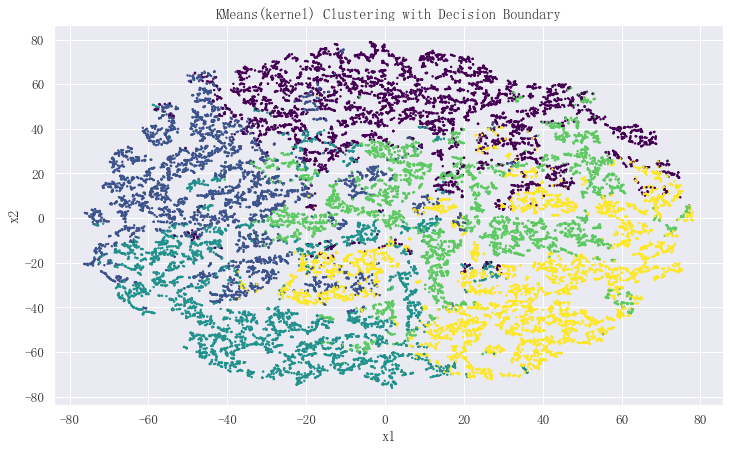

the silhouette score: 0.6181961074471474


In [24]:
# 谱聚类（核KMeans）
# https://blog.csdn.net/chinaherolts2008/article/details/119567308
# https://zhuanlan.zhihu.com/p/603376224?utm_id=0 

clust = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=100, 
                           assign_labels='discretize', degree=3, n_jobs=-1, random_state=42)
clust.fit(np.array(df_pca.iloc[:,2:]))

x1 = X_tsne[:,0]
x2 = X_tsne[:,1]
z = clust.labels_ 

# 绘制原始数据和聚类中心  
plt.figure(figsize=(12,7))
plt.scatter(x1, x2, c=z, cmap='viridis', marker='o', s=2)  


plt.title('KMeans(kernel) Clustering with Decision Boundary')  
plt.xlabel('x1')  
plt.ylabel('x2')  
plt.show()


# 轮廓系数
silhouette = silhouette_score(X_tsne, z)
print("the silhouette score: {}".format(silhouette+0.5))

# 推荐算法

In [ ]:
从综合评分开始改起
客户降维依据：客户年龄、(加上客户收入(500-10000美元)、客户体重(40-120kg)、客户历史订单量(0-400)，均高斯生成)
服装降维依据：尺寸分类、服装类别、服装品类
综合评分：置信度*客户评分*map(评论态度,±1)*正反馈计数   
聚类依据同降维依据
客户簇->服装簇PMF：依据综合评分
正反馈计数的统计绘图加在情感分析处


### 聚类数据集

In [ ]:
# 项目源
# https://blog.csdn.net/fjssharpsword/article/details/96823817
# https://github.com/XiuzeZhou/Recommender-Systems/blob/master/pmf.py

In [ ]:
# 服装聚类
clust = KMeans(n_clusters=32, init='k-means++')
arr_pca = np.array(df_pca[['clothing_pca1','clothing_pca2']])
clust.fit_predict(arr_pca)
clothingclusts = clust.labels_

# 客户聚类
clust = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=100, 
                           assign_labels='discretize', degree=3, n_jobs=-1, random_state=42)
clust.fit_predict(np.array(df_pca.iloc[:,2:]))
clientclusts = clust.labels_

### 簇评分均值

In [ ]:
# 每类客户簇对每类服装簇的打分取均值

# 簇样本
df_clust = pd.DataFrame({'服装ID':df['服装ID'], 
                          '综合评分':df['综合评分'],
                          '客户簇标签':[i for i in clientclusts],
                          '服装簇标签':[i for i in clothingclusts]})


In [ ]:
df_score = df_clust.groupby(['客户簇标签', '服装簇标签']).agg({'综合评分': 'mean'}).reset_index()
df_score['综合评分'] = df_score['综合评分'].astype(int)

arr_score = np.array(df_score)
score_train, score_test, score_val = split_dataset(arr_score, train_ratio=0.6, test_ratio=0.2)

df_score.head(10)

### 模型定义

In [ ]:
# pmf算法
class pmf():
    def __init__(self, 
                 train_list,           
                 test_list,            
                 N,                     # 用户簇数量
                 M,                     # 服装簇数量
                 K=10,                  # 潜在因子数
                 learning_rate=0.001,   
                 lamda_regularizer=0.1, # 回归正则化系数
                 max_iteration=50       
                ):
        self.train_list = train_list
        self.test_list = test_list
        self.N = N
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        self.lamda_regularizer = lamda_regularizer
        self.max_iteration = max_iteration
    
    
    def train(self):
        P = np.random.normal(0, 0.1, (self.N, self.K))
        Q = np.random.normal(0, 0.1, (self.M, self.K))

        train_mat = sequence2mat(sequence = self.train_list, N = self.N, M = self.M)
        test_mat = sequence2mat(sequence = self.test_list, N = self.N, M = self.M)

        records_list = []
        for step in range(self.max_iteration):
            los=0.0
            for data in self.train_list:
                u,i,r = data
                P[u],Q[i],ls = self.update(P[u], Q[i], r=r, 
                                           learning_rate=self.learning_rate, 
                                           lamda_regularizer=self.lamda_regularizer)
                los += ls
            pred_mat = self.prediction(P,Q)
            mae, rmse, recall, precision = evaluation(pred_mat, train_mat, test_mat)
            records_list.append(np.array([los, mae, rmse, recall, precision]))

            if step % 10 ==0:
                print(' step:%d \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
                      %(step,los,mae,rmse,recall,precision))

        print(' end. \n loss:%.4f,mae:%.4f,rmse:%.4f,recall:%.4f,precision:%.4f'
              %(records_list[-1][0],records_list[-1][1],records_list[-1][2],records_list[-1][3],records_list[-1][4]))
        return P, Q, np.array(records_list)


    def update(self, p, q, r, learning_rate=0.001, lamda_regularizer=0.1):
        error = r - np.dot(p, q.T)            
        p = p + learning_rate*(error*q - lamda_regularizer*p)
        q = q + learning_rate*(error*p - lamda_regularizer*q)
        loss = 0.5 * (error**2 + lamda_regularizer*(np.square(p).sum() + np.square(q).sum()))
        return p, q, loss


    def prediction(self, P, Q):
        N,K = P.shape
        M,K = Q.shape

        rating_list=[]
        for u in range(N):
            u_rating = np.sum(P[u,:]*Q, axis=1)
            rating_list.append(u_rating)
        r_pred = np.array(rating_list)
        return r_pred

    # 矩阵转换
    def sequence2mat(sequence, N, M):
        # input:
        # sequence: the list of rating information
        # N: row number, i.e. the number of users
        # M: column number, i.e. the number of items
        # output:
        # mat: user-item rating matrix
        records_array = np.array(sequence)
        mat = np.zeros([N,M])
        row = records_array[:,0].astype(int)
        col = records_array[:,1].astype(int)
        values = records_array[:,2].astype(np.float32)
        mat[row,col]=values
        return mat

In [ ]:
# 指标计算函数

# 索引获取函数
def get_topn(r_pred, train_mat, n=10):
    unrated_items = r_pred * (train_mat==0)
    idx = np.argsort(-unrated_items)
    return idx[:,:n]

# 召回率计算函数
def recall_precision(topn, test_mat):
    n,m = test_mat.shape
    hits,total_pred,total_true = 0.,0.,0.
    for u in range(n):
        hits += len([i for i in topn[u,:] if test_mat[u,i]>0])
        size_pred = len(topn[u,:])
        size_true = np.sum(test_mat[u,:]>0,axis=0)
        total_pred += size_pred
        total_true += size_true

    recall = hits/total_true
    precision = hits/total_pred
    return recall, precision

#平均绝对误差 均方根误差计算函数
def mae_rmse(r_pred, test_mat):
    y_pred = r_pred[test_mat>0]
    y_true = test_mat[test_mat>0]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse 

# 评估器
def evaluation(pred_mat, train_mat, test_mat):
    topn = get_topn(pred_mat, train_mat, n=10)
    mae, rmse = mae_rmse(pred_mat, test_mat)
    recall, precision = recall_precision(topn, test_mat)
    return mae, rmse, recall, precision

# 迭代结果绘图
def figure(values_list, name=''):
    plt.figure(figsize=(12,7))
    x = range(len(values_list))
    plt.plot(x, values_list, color='g',linewidth=3)
    plt.title(name + ' curve')
    plt.xlabel('Iterations')
    plt.ylabel(name)
    plt.show()

### 模型预测

In [ ]:
# 参数设置
N = 5 # 用户簇数量
M = 32 # 服装簇数量
learning_rate = 0.005
lamda_regularizer = 0.1 # 回归正则化系数
max_iteration = 150
K = 10 # 潜在因子数

# 数据处理
train_list = [list(i) for i in score_train]
test_list = [list(i) for i in score_test]

# 训练模型
model = pmf(train_list=score_train, 
            test_list=score_test, 
            N=N, 
            M=M,
            K=K,
            learning_rate=learning_rate, 
            lamda_regularizer=lamda_regularizer, 
            max_iteration=max_iteration)
P, Q, records_array = model.train()
print('MAE:%.4f;RMSE:%.4f;Recall:%.4f;Precision:%.4f'
      %(records_array[:,1][-1],records_array[:,2][-1],records_array[:,3][-1],records_array[:,4][-1]))

figure(values_list=records_array[:,0],name='loss')
figure(values_list=records_array[:,1],name='MAE')

# 模型验证

# 代码备份

In [ ]:
dfr = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
dfr['Revenue'] = [np.abs(int(i)) for i in np.random.normal(loc=2231.2, scale=2000, size=(1,len(dfr['Age'])))[0]] 
dfr['Weight'] =  [np.abs(np.round(i,1)) for i in np.random.normal(loc=75.2, scale=10, size=(1,len(dfr['Age'])))[0]] 
dfr['Historical Order Quantity'] = [np.abs(int(i)) for i in np.random.normal(loc=53, scale=30, size=(1,len(dfr['Age'])))[0]] 
dfr = dfr.drop(columns=["Title"])

dfr.to_csv("Womens Clothing E-Commerce Reviews-folded.csv", index=False)
dfr.head()

In [ ]:
# clust = OPTICS(min_samples=400, xi=0.05)
# clust.fit(arr_scaled)

# plt.figure(figsize=(12,7))
# plt.scatter(X_tsne[:,0], X_tsne[:,1], s=180, c=clust.labels_, cmap='tab20')



In [ ]:
# arr_pca = np.array(df_pca.iloc[:3000,2:])
# 开始聚类(方法1，线性边界，效果不好，需要改进)
clust = KMeans(n_clusters=4, init='k-means++', max_iter=500)
clust.fit(np.array(df_pca.iloc[:,2:])) 

x1 = X_tsne[:,0]
x2 = X_tsne[:,1]
z = clust.labels_ 

# 绘制原始数据和聚类中心  
plt.figure(figsize=(12,7))
plt.scatter(x1, x2, c=z, cmap='viridis', marker='o', s=3)  
# plt.scatter(clust.cluster_centers_[:, 0], clust.cluster_centers_[:, 1], c='black', marker='x', s=2)  


# # 估算决策边界  
# x_min, x_max = x1.min() - 1, x1.max() + 1  
# y_min, y_max = x2.min() - 1, x2.max() + 1  
# xx, yy = np.meshgrid(np.arange(x_min-10, x_max+10, 5), np.arange(y_min-10, y_max+10, 5))  
# Z = clust.fit_predict(np.c_[xx.ravel(), yy.ravel()])  

# # 绘制分界线  
# Z = Z.reshape(xx.shape)  
# plt.contourf(xx, yy, Z, alpha=0.2)  

plt.title('KMeans Clustering with Decision Boundary')  
plt.xlabel('x1')  
plt.ylabel('x2')  
plt.show()


In [69]:

class KMeansClassifier():
    """初始化KMeansClassifier类"""
    def __init__(self, k=3, initCent='random', max_iter=500):
        # 类的成员数据(变量前用下划线)
        self._k = k # 中心点
        self._initCent = initCent # 生成初始中心点
        self._max_iter = max_iter # 最大迭代次数
        self._clusterAssment = None # 点分配结果
        self._labels = None
        self._sse = None # 误差平方和
        
        
    def _calEDist(self, arrA, arrB):
        """计算欧氏距离，参数为两个一维数组"""
        return np.math.sqrt(sum(np.power(arrA-arrB, 2)))
    
    
    def _calMDist(self, arrA, arrB):
        """计算曼哈顿距离，参数为两个一维数组"""
        return sum(np.abs(arrA-arrB))


    def _randCent(self, data_X, k):
        """随机选取k个质心，返回一个k*n的质心矩阵"""
        n = data_X.shape[1] # 特征的维度
        centroids = np.empty((k,n)) # 使用numpy生成一个k*n的矩阵，用于存储质心
        for j in range(n):
            minJ = min(data_X[:, j])
            rangeJ = float(max(data_X[:, j] - minJ))
            centroids[:, j] = (minJ + rangeJ * np.random.rand(k, 1)).flatten() # 使用flatten函数展平嵌套列表(nested list)
        return centroids
    
    
    def fit(self, data_X):
        """参数为m*n维矩阵"""
        if not isinstance(data_X, np.ndarray):
            data_X = np.asarray(data_X)

        m = data_X.shape[0] # 样本的个数
        self._clusterAssment = np.zeros((m,2)) # 一个m*2维矩阵，矩阵第一列存储样本点所属的簇的索引值，第二列存储该点与所属簇的质心的平方误差
        
        if self._initCent == 'random':
            self._centroids = self._randCent(data_X, self._k)
            
        clusterChanged = True
        for _ in range(self._max_iter):
            clusterChanged = False
            for i in range(m): # 将每个样本点分配到离它最近的质心所属的簇
                minDist = np.inf # 首先将minDist置为一个无穷大的数
                minIndex = -1 # 将最近质心的下标置为-1
                for j in range(self._k): # k次迭代用于寻找最近的质心
                    arrA = self._centroids[j,:]
                    arrB = data_X[i,:]
                    distJI = self._calEDist(arrA, arrB) # 计算误差值
                    if distJI < minDist:
                        minDist = distJI
                        minIndex = j
                if self._clusterAssment[i, 0] != minIndex or self._clusterAssment[i, 1] > minDist**2:
                    clusterChanged = True
                    self._clusterAssment[i,:] = minIndex, minDist**2
            if not clusterChanged: # 若所有样本点所属的簇都不改变,则已收敛,结束迭代
                break
            # 更新质心，将每个簇中的点的均值作为质心
            for i in range(self._k):
                index_all = self._clusterAssment[:,0] # 取出样本所属簇的索引值
                value = np.nonzero(index_all==i) # 取出所有属于第i个簇的索引值
                ptsInClust = data_X[value[0]] # 取出属于第i个簇的所有样本点
                self._centroids[i,:] = np.mean(ptsInClust, axis=0) # 计算均值
        
        self._labels = self._clusterAssment[:,0]
        self._sse = sum(self._clusterAssment[:,1])
    
    def predict(self, X):
        """根据聚类结果，预测新输入数据所属的族"""
        if not isinstance(X,np.ndarray):
            X = np.asarray(X)
        
        m = X.shape[0] # m代表样本数量
        preds = np.empty((m,))
        # 将每个样本点分配到离它最近的质心所属的族
        for i in range(m):
            minDist = np.inf
            for j in range(self._k):
                distJI = self._calEDist(self._centroids[j,:], X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds
    
    
class biKMeansClassifier():
    """初始化biKMeansClassifier类"""
    def __init__(self, k=3):
        self._k = k
        self._centroids = None
        self._clusterAssment = None
        self._labels = None
        self._sse = None
        
    
    def _calEDist(self, arrA, arrB):
        """计算欧氏距离，参数为两个一维数组"""
        return np.math.sqrt(sum(np.power(arrA-arrB, 2)))
        
        
    def fit(self, X):
        m = X.shape[0]
        self._clusterAssment = np.zeros((m,2))
        # 创建初始簇
        centroid0 = np.mean(X, axis=0).tolist()
        centList =[centroid0]
        for j in range(m): # 计算每个样本点与质心之间初始的平方误差
            self._clusterAssment[j,1] = self._calEDist(np.asarray(centroid0), X[j,:])**2
        
        while (len(centList) < self._k):
            lowestSSE = np.inf
            # 尝试划分每一簇,选取使得误差最小的那个簇进行划分
            for i in range(len(centList)):
                index_all = self._clusterAssment[:,0] # 取出样本所属簇的索引值
                value = np.nonzero(index_all==i) # 取出所有属于第i个簇的索引值
                ptsInCurrCluster = X[value[0],:] # 取出属于第i个簇的所有样本点
                clf = KMeansClassifier(k=2)
                clf.fit(ptsInCurrCluster)
                # 划分该簇后，所得到的质心、分配结果及误差矩阵
                centroidMat, splitClustAss = clf._centroids, clf._clusterAssment
                sseSplit = sum(splitClustAss[:,1])
                index_all = self._clusterAssment[:,0] 
                value = np.nonzero(index_all==i)
                sseNotSplit = sum(self._clusterAssment[value[0],1])
                if (sseSplit + sseNotSplit) < lowestSSE:
                    bestCentToSplit = i
                    bestNewCents = centroidMat
                    bestClustAss = splitClustAss.copy()
                    lowestSSE = sseSplit + sseNotSplit
            # 该簇被划分成两个子簇后,其中一个子簇的索引变为原簇的索引
            # 另一个子簇的索引变为len(centList),然后存入centList
            bestClustAss[np.nonzero(bestClustAss[:,0]==1)[0],0]=len(centList)
            bestClustAss[np.nonzero(bestClustAss[:,0]==0)[0],0]=bestCentToSplit
            centList[bestCentToSplit] = bestNewCents[0,:].tolist()
            centList.append(bestNewCents[1,:].tolist())
            self._clusterAssment[np.nonzero(self._clusterAssment[:,0] == bestCentToSplit)[0],:]= bestClustAss 
                   
        self._labels = self._clusterAssment[:,0] 
        self._sse = sum(self._clusterAssment[:,1])
        self._centroids = np.asarray(centList)
    
    
    def predict(self, X):
        """根据聚类结果，预测新输入数据所属的族"""
        if not isinstance(X,np.ndarray):
            X = np.asarray(X)
        
        m = X.shape[0] # m代表样本数量
        preds = np.empty((m,))
        for i in range(m): # 将每个样本点分配到离它最近的质心所属的族
            minDist = np.inf
            for j in range(self._k):
                distJI = self._calEDist(self._centroids[j,:],X[i,:])
                if distJI < minDist:
                    minDist = distJI
                    preds[i] = j
        return preds


In [56]:
# 切分数据集
df_train, df_test, df_val = split_dataset(np.array(df_scaled), train_ratio=0.6, test_ratio=0.2)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
# 开始聚类
clust = KMeans(n_clusters=4, init='k-means++', max_iter=1000)
clust.fit(np.array(df_pca.iloc[:,2:])) 

x1 = X_tsne[:,0]
x2 = X_tsne[:,1]
z = clust.labels_ 

# 绘制原始数据和聚类中心  
plt.figure(figsize=(12,7))
plt.scatter(x1, x2, c=z, cmap='viridis', marker='o', s=3)  


plt.title('KMeans Clustering with Decision Boundary')  
plt.xlabel('x1')  
plt.ylabel('x2')  
plt.show()

'''
KMeans只能处理线性边界，效果不好，需要改进

'''

In [85]:
if __name__=="__main__":
    
    data_X = np.array(df_bkmean.loc[:,['pca1','pca2']])
    
    # 训练模型
    for k in range(1,15):
        clf = biKMeansClassifier(k) # 实例化biKMeansClassifier类
        clf.fit(data_X) # 训练模型
        cents = clf._centroids
        labels = clf._labels
        sse = clf._sse
        print("k={}, SSE={:.2f}, cent={}".format(k, sse, cents))

k=1, SSE=54884.87, cent=[[-0.00128489  0.01491646]]
k=2, SSE=27316.87, cent=[[ 0.32320551  1.4616569 ]
 [-0.11395624 -0.48742875]]
k=3, SSE=26775.49, cent=[[-2.54151957  1.52004239]
 [ 0.1367025  -0.14311694]
 [-1.7090631   2.95888903]]
k=4, SSE=11675.72, cent=[[ 0.3622429  -0.57817361]
 [ 0.32320551  1.4616569 ]
 [-1.2493921  -0.29262591]
 [-2.99052324  0.74396885]]
k=5, SSE=10795.13, cent=[[ 1.04873793  0.88399841]
 [-1.21618084 -0.22029762]
 [ 0.6410583  -0.31985838]
 [ 1.01091581  2.63961622]
 [ 0.66940065  2.04932956]]


ValueError: min() arg is an empty sequence

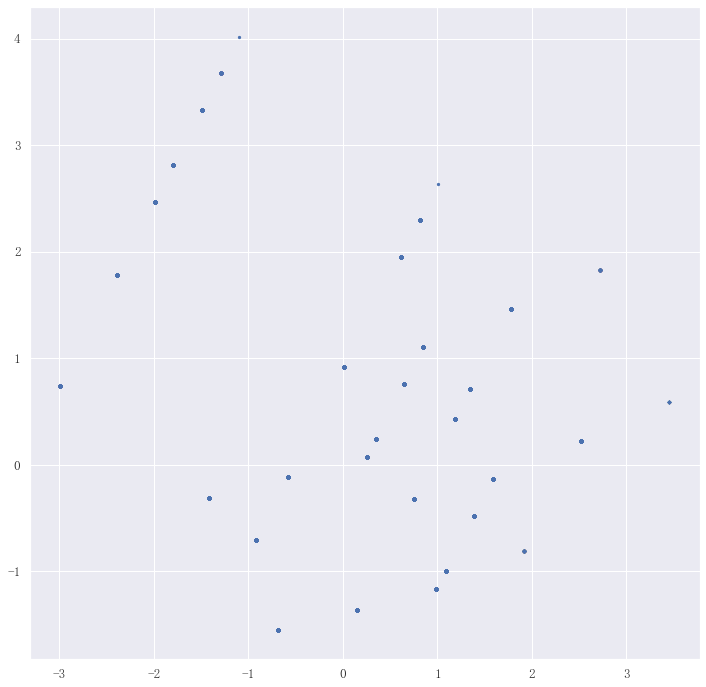

In [100]:
import operator
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# 显示决策图
def plotReachability(data,eps):
    plt.figure()
    plt.plot(range(0,len(data)), data)
    plt.plot([0, len(data)], [eps, eps])
    plt.show()

# 显示分类的类别
def plotFeature(data,labels):
    clusterNum = len(set(labels))
    fig = plt.figure()
    scatterColors = ['black', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'brown']
    ax = fig.add_subplot(111)
    for i in range(-1, clusterNum):
        colorSytle = scatterColors[i % len(scatterColors)]
        subCluster = data[np.where(labels == i)]
        ax.scatter(subCluster[:, 0], subCluster[:, 1], c=colorSytle, s=12)
    plt.show()

class OPTICS1(object):
    def __init__(self,data,eps=np.inf,minPts=15):
        self.data=data
        self.disMat = self.compute_squared_EDM(data)  # 获得距离矩阵
        self.number_sample=data.shape[0]
        self.eps=eps
        self.minPts=minPts
        self.core_distances = self.disMat[np.arange(0, self.number_sample), np.argsort(self.disMat)[:, minPts - 1]]  # 计算核心距离
        self.core_points_index = np.where(np.sum(np.where(self.disMat <= self.eps, 1, 0), axis=1) >= self.minPts)[0]

    # 计算距离矩阵
    def compute_squared_EDM(self,X):
        return squareform(pdist(X, metric='euclidean'))
    #训练
    def train(self):
        # 初始化每一个点的最终可达距离(未定义)
        self.reach_dists = np.full((self.number_sample,), np.nan)
        self.orders=[]#结果数组
        start_core_point=self.core_points_index[0]#从一个核心点开始
        #标记数组
        isProcess = np.full((self.number_sample,), -1)

        #训练
        isProcess[start_core_point] = 1
        #选择一个核心点作为开始节点，并将其核心距离作为可达距离
        self.reach_dists[start_core_point] = self.core_distances[start_core_point]
        self.orders.append(start_core_point)  # 加入结果数组
        seeds = {}#种子数组，或者叫排序数组
        seeds = self.updateSeeds(seeds, start_core_point, isProcess)#更新排序数组
        while len(seeds) > 0:
            nextId = sorted(seeds.items(), key=operator.itemgetter(1))[0][0]  # 按可达距离排序，取第一个(最小的)
            del seeds[nextId]
            isProcess[nextId] = 1
            self.orders.append(nextId)  # 加入结果数组
            seeds = self.updateSeeds(seeds, nextId, isProcess)#更新种子数组和可达距离数组的可达距离

    #更新可达距离
    def updateSeeds(self,seeds, core_PointId, isProcess):
        # 获得核心点core_PointId的核心距离
        core_dist = self.core_distances[core_PointId]
        # 计算所未访问的样本点更新可达距离
        for i in range(self.number_sample):
            if (isProcess[i] == -1):
                # 计算可达距离
                new_reach_dist = max(core_dist, self.disMat[core_PointId][i])
                if (np.isnan(self.reach_dists[i])):
                    # 可达矩阵更新
                    self.reach_dists[i] = new_reach_dist
                    seeds[i] = new_reach_dist
                elif (new_reach_dist < self.reach_dists[i]):
                    self.reach_dists[i] = new_reach_dist
                    seeds[i] = new_reach_dist
        return seeds
    #生成label
    def predict(self):
        clusterId = 0
        self.labels = np.full((self.number_sample,), -1)
        for i in self.orders:
            if self.reach_dists[i]<=self.eps:
                self.labels[i]=clusterId
            else:
                if self.core_distances[i]<=self.eps:
                    clusterId +=1
                    self.labels[i] = clusterId
                    
if __name__ == '__main__':
    data = data_X
    OP=OPTICS1(data, 3, 1)
    OP.train()
    OP.predict()
    plotReachability(OP.reach_dists[OP.orders],3)
    plotFeature(data,OP.labels)


KeyboardInterrupt: 